<div>
    <h1 style="text-align:center"> A Step-By-Step Guide to GHG Calculations with RE-Emission </h1>
    <h3> This notebook demonstrates how to: </h3>
 <ol>
  <li>Manually construct input data structures for a hypotethical reservoir </li>
  <li>Instantiate Catchment and Reservoir objects </li>
     <li>Calculate $CO_2$, $CH_4$ and $N_2O$ <b>emission factors</b> </li>
  <li>Calculate $CO_2$, $CH_4$ and $N_2O$ <b>emission profile</b> </li>
</ol> 
</div>

### Import required libraries and RE-Emission classes

In [1]:
import sys
import matplotlib.pyplot as plt
try:
    import reemission
except ImportError:
    %pip install git+https://github.com/tomjanus/reemission.git --quiet
# Import from the temperature module
from reemission.temperature import MonthlyTemperature
# Import from the emissions module
from reemission.emissions import CarbonDioxideEmission, NitrousOxideEmission, MethaneEmission
# Import from the constants module
from reemission.constants import Landuse, Climate, SoilType, Biome, TreatmentFactor, LanduseIntensity
# Import from the catchment module
from reemission.catchment import Catchment
# Import from the reservoir module
from reemission.reservoir import Reservoir
# Import from the biogenic module
from reemission.biogenic import BiogenicFactors

### 1. Prepare Input Data

In [2]:
# Define a typical monthly temperature profile in the location where reservoir is situated
mt = MonthlyTemperature([10.56,11.99,15.46,18.29,20.79,22.09,22.46,22.66,21.93,19.33,15.03,11.66])
# Reservoir coordinates (lat, long)
coordinates = [22.6, 94.7]
# Define categorical properties of the catchment.
# These properties define the biome, climate, type of soil, degree of wastewater treatment in the area
# and agricultural land use intensity
biogenic_factors = BiogenicFactors(biome = Biome.TROPICALMOISTBROADLEAF,
                                   climate = Climate.TROPICAL,
                                   soil_type=SoilType.MINERAL,
                                   treatment_factor = TreatmentFactor.NONE,
                                   landuse_intensity = LanduseIntensity.LOW)
# Define area fractions allocated to different available landuses
# The supported landuses are:
# 'bare', 'snow_ice', 'urban', 'water', 'wetlands', 'crops', 'shrubs', 'forest'
# and can be listed as follows:
# landuses = [landuse.value for landuse in Landuse]
catchment_area_fractions = [
    0.0, 0.0, 0.0, 0.0, 0.0, 0.01092, 0.11996, 0.867257, 0.0]
reservoir_area_fractions = [
    0.0, 0.0, 0.0, 0.0, 0.0, 0.45, 0.15, 0.4, 0.0, 
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0,  0.0,  0.0, 0.0, 
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0,  0.0,  0.0, 0.0]
# Define a dictionary of catchment inputs
catchment_inputs = {'runoff': 1685.5619, 'area': 78203.0, 'population': 8463, 'riv_length': 9.2, 
                    'area_fractions': catchment_area_fractions, 'slope': 8.0, 'precip': 2000.0, 
                    'etransp': 400.0, 'soil_wetness': 140.0, 'mean_olsen': 5.85, 'biogenic_factors': biogenic_factors}
# Define a dictionary of reservoir inputs
reservoir_inputs = {'volume': 7663812, 'area': 100.56470, 'max_depth': 32.0, 'mean_depth': 13.6,
                   'area_fractions': reservoir_area_fractions, 'soil_carbon': 10.228,
                   'mean_radiance': 4.5, 'mean_radiance_may_sept': 4.5, 'mean_radiance_nov_mar': 3.2,
                   'mean_monthly_windspeed': 3.8, 'water_intake_depth': 20.0}    
# Define a vector of years for which emission profile value shall be calculated
year_profile = (1, 5, 10, 20, 30, 40, 50, 65, 80, 100)

### 2. Initialize Catchment and Reservoir Objects

In [3]:
catchment_1 = Catchment(**catchment_inputs)
reservoir_1 = Reservoir(**reservoir_inputs, temperature = mt,
                        coordinates=coordinates,inflow_rate=catchment_1.discharge)

### 3. Calculate $CO_2$ emissions

In [4]:
# Instantiate CarbonDioxideEmission object with catchment and reservoir input data and temperature vector
em_co2 = CarbonDioxideEmission(
    catchment=catchment_1, reservoir=reservoir_1,
    eff_temp=mt.eff_temp(gas='co2'), p_calc_method='g-res')
# Calculate CO2 emission profile and CO2 emission factor, respectively
co2_emission_profile = em_co2.profile(years = year_profile)
co2_emission_factor = em_co2.factor(number_of_years = year_profile[-1])
print('CO2 emission profile (g CO2eq m-2 yr-1): ', *[
    "Year: %d \t Emission: %.2f" % (year, flux) for year, flux in zip(
        year_profile, co2_emission_profile)], sep='\n* ')   

CO2 emission profile (g CO2eq m-2 yr-1): 
* Year: 1 	 Emission: 1158.95
* Year: 5 	 Emission: 655.97
* Year: 10 	 Emission: 509.23
* Year: 20 	 Emission: 392.49
* Year: 30 	 Emission: 335.61
* Year: 40 	 Emission: 299.62
* Year: 50 	 Emission: 273.97
* Year: 65 	 Emission: 246.13
* Year: 80 	 Emission: 225.74
* Year: 100 	 Emission: 205.33


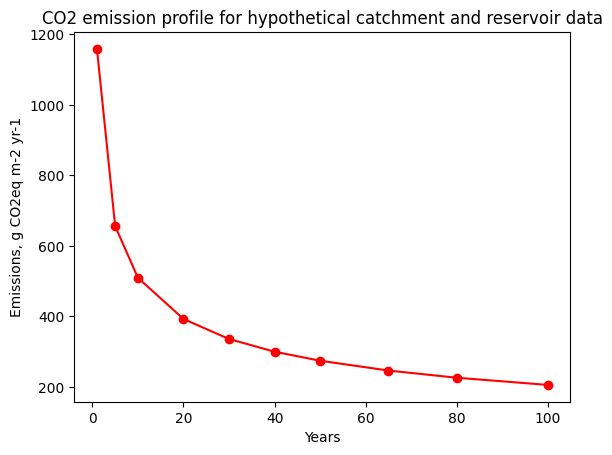

In [5]:
# Plot the CO2 emission profile
plt.plot(year_profile, co2_emission_profile, 'r-o') 
plt.xlabel('Years') 
plt.ylabel('Emissions, g CO2eq m-2 yr-1') 
plt.title('CO2 emission profile for hypothetical catchment and reservoir data') 
plt.show()

In [6]:
print('CO2 emission factor (g CO2eq m-2 yr-1): ', "%.2f" % co2_emission_factor)

CO2 emission factor (g CO2eq m-2 yr-1):  327.41


### 4. Calculate $N_2O$ emissions

In [7]:
# Instantiate NitrousOxideEmission object with catchment and reservoir input data
em_n2o = NitrousOxideEmission(
    catchment=catchment_1, reservoir=reservoir_1, model='model_1', p_export_model='g-res')
# Calculate N2O emission profile and CO2 emission factor, respectively
# (Note that N2O emission profile is flat because N2O emission does not have time-dependency)
n2o_emission_profile = em_n2o.profile(years = year_profile)
n2o_emission_factor = em_n2o.factor()
print('N2O emission profile (g CO2eq m-2 yr-1): ', *[
    "Year: %d \t Emission: %.2f" % (year, flux) for year, flux in zip(
        year_profile, n2o_emission_profile)], sep='\n* ')   

N2O emission profile (g CO2eq m-2 yr-1): 
* Year: 1 	 Emission: 0.01
* Year: 5 	 Emission: 0.01
* Year: 10 	 Emission: 0.01
* Year: 20 	 Emission: 0.01
* Year: 30 	 Emission: 0.01
* Year: 40 	 Emission: 0.01
* Year: 50 	 Emission: 0.01
* Year: 65 	 Emission: 0.01
* Year: 80 	 Emission: 0.01
* Year: 100 	 Emission: 0.01


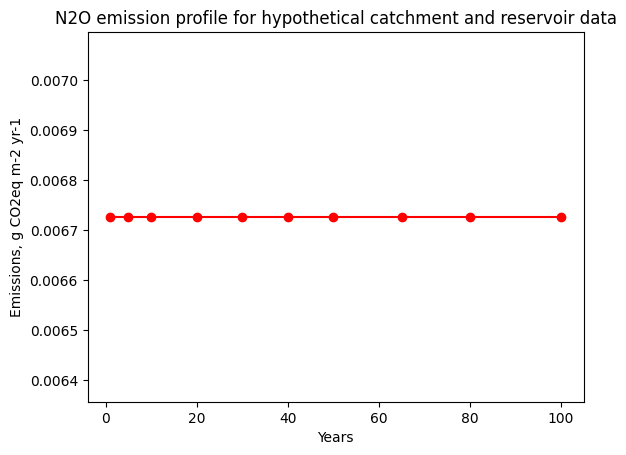

In [8]:
# Plot the N2O emission profile
plt.plot(year_profile, n2o_emission_profile, 'r-o') 
plt.xlabel('Years') 
plt.ylabel('Emissions, g CO2eq m-2 yr-1') 
plt.title('N2O emission profile for hypothetical catchment and reservoir data') 
plt.show()

In [9]:
print('N2O emission factor (g CO2eq m-2 yr-1): ', "%.2f" % n2o_emission_factor)

N2O emission factor (g CO2eq m-2 yr-1):  0.01


### 5. Calculate downstream TN load and concentration from the reservoir

In [10]:
# For TN we can calculate downstream TN load and concentration in the effluent from the reservoir
# This feature can be used to evaluate emissions taking into account nitrogen mass balance in upstream
# reservoirs on the emissions in the reservoirs downstream
tn_downstream_load = em_n2o.nitrogen_downstream_load()/1_000
tn_downstream_conc = em_n2o.nitrogen_downstream_conc()
print('TN downstream load (tN yr-1): ', "%.1f" % tn_downstream_load)
print('TN downstream concentration (mgN / L): ', "%.4f" % tn_downstream_conc)

TN downstream load (tN yr-1):  6595.1
TN downstream concentration (mgN / L):  0.0500


### 6. Calculate $CH_4$ emissions

In [11]:
# Instantiate MethaneEmission object with catchment and reservoir input data, montnly temperature
# profile and mean irradiation
em_ch4 = MethaneEmission(catchment=catchment_1, reservoir=reservoir_1, monthly_temp=mt)
# Calculate CH4 emission profile and CH4 emission factor, respectively
ch4_emission_profile = em_ch4.profile(years = year_profile)
ch4_emission_factor = em_ch4.factor()
print('CH4 emission profile (g CO2eq m-2 yr-1): ', *[
    "Year: %d \t Emission: %.2f" % (year, flux) for year, flux in zip(
        year_profile, ch4_emission_profile)], sep='\n* ') 

CH4 emission profile (g CO2eq m-2 yr-1): 
* Year: 1 	 Emission: 438.64
* Year: 5 	 Emission: 395.71
* Year: 10 	 Emission: 349.36
* Year: 20 	 Emission: 276.56
* Year: 30 	 Emission: 224.05
* Year: 40 	 Emission: 186.18
* Year: 50 	 Emission: 158.86
* Year: 65 	 Emission: 131.48
* Year: 80 	 Emission: 114.70
* Year: 100 	 Emission: 101.98


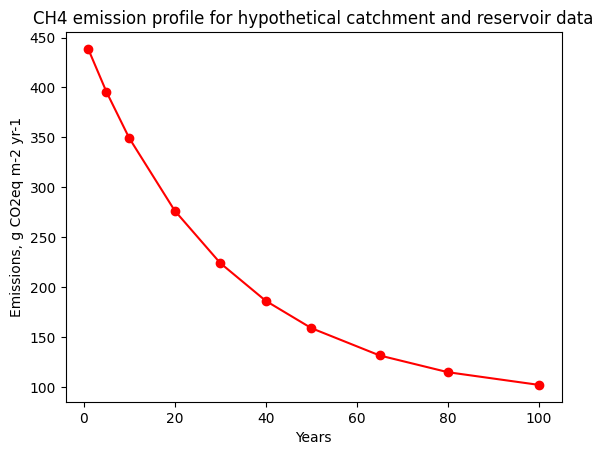

In [12]:
# Plot the CH4 emission profile
plt.plot(year_profile, ch4_emission_profile, 'r-o') 
plt.xlabel('Years') 
plt.ylabel('Emissions, g CO2eq m-2 yr-1') 
plt.title('CH4 emission profile for hypothetical catchment and reservoir data') 
plt.show()

<a href="https://colab.research.google.com/github/tomjanus/re-emission/blob/master/docs/notebooks/01-Step-By-Step-Manual-Calculations.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>